In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

In [2]:
df = pd.read_csv('wine-reviews.csv', usecols = ['country', 'description', 'points', 'price', 'variety', 'winery'])
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [3]:
df = df.dropna(subset=["description", "points"])
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


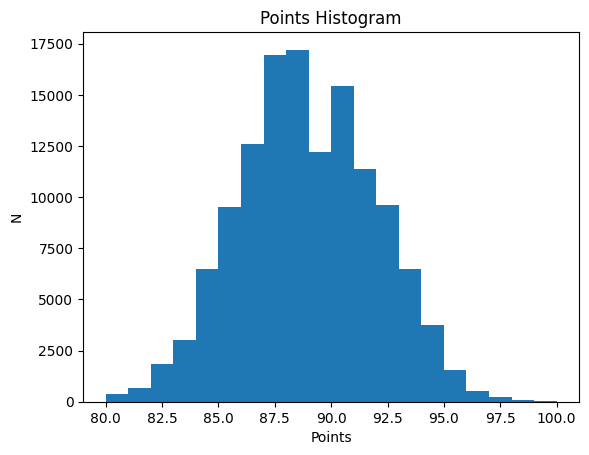

In [4]:
plt.hist(df.points, bins=20)
plt.title('Points Histogram')
plt.ylabel('N')
plt.xlabel("Points")
plt.show()

In [5]:
df["label"] = (df.points >= 90).astype(int)
df = df[["description", "label"]]
df.head()

,description,label
0,"Aromas include tropical fruit, broom, brimston...",0
1,"This is ripe and fruity, a wine that is smooth...",0
2,"Tart and snappy, the flavors of lime flesh and...",0
3,"Pineapple rind, lemon pith and orange blossom ...",0
4,"Much like the regular bottling from 2012, this...",0


In [6]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [7]:
len(train), len(val), len(test)

(103976, 12997, 12998)

In [8]:
print(train)

                                              description  label
50491   Jammy in blackberry, raspberry and mulberry fl...      0
129963  A bouquet of black cherry, tart cranberry and ...      1
3157    Fresh and reasonably fruity on the nose, but i...      0
35887   There are some elegant floral highlights in th...      0
76366   This is a fruity, up-front wine that's full of...      0
...                                                   ...    ...
13592   Blackberry, leather, clove and dark cooking sp...      0
116600  Aromas of orange blossom and jasmine intoxicat...      1
42926   This soft wine has a smooth texture and and a ...      0
23321   Delicate aromas of red berry mix with scents o...      0
78112   This opens with deep, dense dark-fruit goodnes...      1

[103976 rows x 2 columns]


In [14]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  #df = {key:value[:, tf.newaxis] for key,value in dataframe.items()}
  #ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [15]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [16]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding,dtype=tf.string,trainable=True)

In [29]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [30]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
             loss=tf.keras.losses.BinaryCrossentropy(),
             metrics=['accuracy'])

In [31]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 36s 345ms/step - loss: 0.6028 - accuracy: 0.6596 - val_loss: 0.4597 - val_accuracy: 0.8031
Epoch 2/5
102/102 [==============================] - 31s 306ms/step - loss: 0.4148 - accuracy: 0.8107 - val_loss: 0.3918 - val_accuracy: 0.8187
Epoch 3/5
102/102 [==============================] - 31s 303ms/step - loss: 0.3464 - accuracy: 0.8567 - val_loss: 0.3902 - val_accuracy: 0.8206
Epoch 4/5
102/102 [==============================] - 34s 336ms/step - loss: 0.3145 - accuracy: 0.8758 - val_loss: 0.4074 - val_accuracy: 0.8261
Epoch 5/5
102/102 [==============================] - 33s 321ms/step - loss: 0.2954 - accuracy: 0.8847 - val_loss: 0.4146 - val_accuracy: 0.8223


In [32]:
model.evaluate(valid_data)

13/13 [==============================] - 1s 46ms/step - loss: 0.4146 - accuracy: 0.8223


[0.4145621359348297, 0.822266697883606]

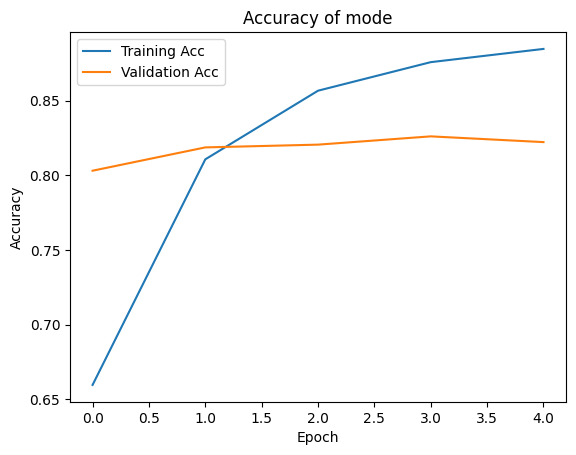

In [33]:
plt.plot(history.history['accuracy'], label='Training Acc')
plt.plot(history.history['val_accuracy'], label='Validation Acc')
plt.title('Accuracy of mode')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

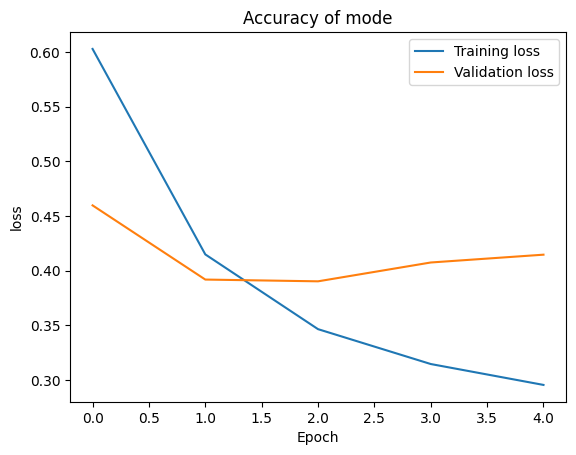

In [34]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Accuracy of mode')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# LSTM

In [36]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label:text))

In [37]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [38]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim = len(encoder.get_vocabulary()),
        output_dim = 32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [40]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
             loss=tf.keras.losses.BinaryCrossentropy(),
             metrics=['accuracy'])

In [ ]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 33s 289ms/step - loss: 0.5506 - accuracy: 0.7080 - val_loss: 0.3803 - val_accuracy: 0.8229
Epoch 2/5
102/102 [==============================] - 32s 311ms/step - loss: 0.3664 - accuracy: 0.8361 - val_loss: 0.3562 - val_accuracy: 0.8340
Epoch 3/5
102/102 [==============================] - 28s 278ms/step - loss: 0.3505 - accuracy: 0.8423 - val_loss: 0.3526 - val_accuracy: 0.8368
Epoch 4/5
 33/102 [========>.....................] - ETA: 16s - loss: 0.3386 - accuracy: 0.8482

In [41]:
model.evaluate(valid_data)

102/102 [==============================] - 12s 96ms/step - loss: 0.6934 - accuracy: 0.4462


[0.6934462189674377, 0.44623759388923645]

In [42]:
model.evaluate(testing_data)

13/13 [==============================] - 1s 79ms/step - loss: 0.6935 - accuracy: 0.4454


[0.6934548020362854, 0.44541049003601074]